In [107]:
# imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import pandas as pd
import copy

%load_ext autoreload
%autoreload 2

np.set_printoptions(precision=4)

from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

Here we reproduce the results from *Identifying and Correcting Label Bias in Machine Learning* [\[Jiang and Nachum 2019\]](https://arxiv.org/pdf/1901.04966.pdf)


The code from the authors could be found [here](https://github.com/google-research/google-research/blob/master/label_bias/)

In [109]:
from fairness import * 
from get_data import get_adult

In [110]:
X_train, X_test, y_train, y_test,\
         protected_train, protected_test = get_adult(random_state=42)

(48842, 15)
(48842, 4)


In [111]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='lbfgs', max_iter=300)
lr.fit(X_train, y_train)
print('Error on test set =', 1-lr.score(X_test, y_test))
y_pred = lr.predict(X_test)

Error on test set = 0.14216689869789534


## 1. Fairness 

There is severals way to define the fairness. 
Here we highlight two kind of fairness:
1. **Demographic parity** [Dwork et al., 2012]() A fair classifier should make positive predictions on protected groups at the same rate as on all of X
2. **Equal opportunity** [Hardt et al., 2016]() A fair classifier should have equal true positive rates on protected groups at the same rate as on all of X

Now if we want to check if the predictions of our model is fair with respect to the protected group, let's examine the confusion matrix for both the protected group and every samples X.

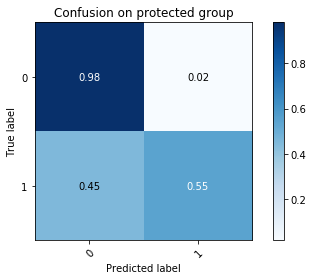

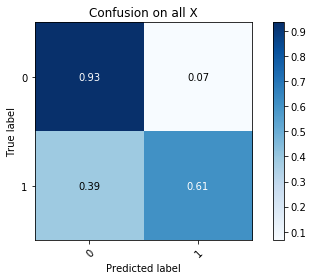

In [112]:
plot_confusion_matrix(y_test[protected_test], y_pred[protected_test], ['0', '1'], normalize=True, title='Confusion on protected group')
plot_confusion_matrix(y_test, y_pred, ['0', '1'], normalize=True, title='Confusion on all X')

With the confusion matrix, we clearly see that the **True Positive Rate** on the protected group (of 0.55) is **lower** than on all X (0.61).  
So our classifier is bias w.r.t. the protected group. That violate the *Equal opportunity* fairness.  

Also the **positive predictions** are **higher** in X all than on the protected group. That violate *the Demographic parity* fairness.

In [125]:
### STD for CM

l_cm_protected, l_cm = [], []

for random_state in range(10):
    X_train, X_test, y_train, y_test,\
         protected_train, protected_test = get_adult(random_state=random_state)
    
    lr = LogisticRegression(solver='lbfgs', max_iter=500)
    lr.fit(X_train, y_train)
#     print('Error on test set =', 1-lr.score(X_test, y_test))
    y_pred = lr.predict(X_test)

    cm_protected = confusion_matrix(y_test[protected_test], y_pred[protected_test])
    cm_protected = cm_protected.astype('float') / cm_protected.sum(axis=1)[:, np.newaxis]
    l_cm_protected.append(cm_protected)
    
    cm = confusion_matrix(y_test, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    l_cm.append(cm)
    
print('cm_protected std:\n', np.asarray(l_cm_protected).std(axis=0))
print('cm std:\n', np.asarray(l_cm).std(axis=0))

In [168]:
# def get_lambda_star():


lambda_ = 0
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr.fit(X_train, y_train)

l_lambda = []
l_delta = []
l_score_test_err = []
l_fairness_violation = []
for t in np.linspace(-2,7, 25):  # range(100): #2.507586
    print(int(t), end=' ')
#     delta = fairness_violation(lr.predict(X_train), y_train,
#                                protected_train, notion='demographic_parity')
#     l_delta.append(delta)
#     lambda_ = lambda_ - delta
    lambda_ = t
    l_lambda.append(lambda_)
    w = reweigth_samples(lambda_, protected_train, y_train)
    lr.fit(X_train, y_train, sample_weight=w)
    l_score_test_err.append(1-lr.score(X_test, y_test))
    l_fairness_violation.append(fairness_violation(lr.predict(X_test), y_test,
                               protected_test, notion='equal_opportunity'))

plt.plot(l_lambda, l_score_test_err, label = 'Error Rate')
plt.plot(l_lambda, np.abs(l_fairness_violation), label = 'Fairness Violation')
plt.xlabel('lambda')
plt.legend()

ValueError: Found input variables with inconsistent numbers of samples: [4875, 36631]

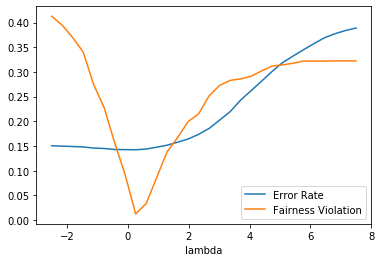

Error on test set = 0.14241257882237324


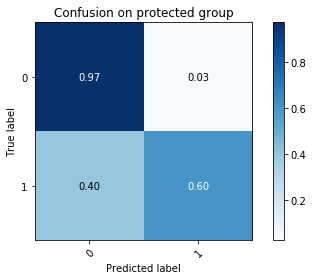

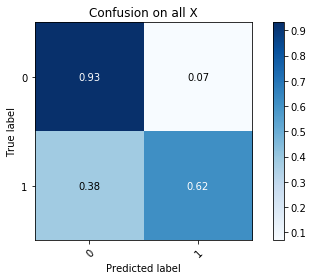

In [95]:
w = reweigth_samples(.26, protected_train, y_train)
lr.fit(X_train, y_train, sample_weight=w)
print('Error on test set =', 1-lr.score(X_test, y_test))
y_pred = lr.predict(X_test)
plot_confusion_matrix(y_test[protected_test], y_pred[protected_test], ['0', '1'], normalize=True, title='Confusion on protected group')
plot_confusion_matrix(y_test, y_pred, ['0', '1'], normalize=True, title='Confusion on all X');

0
-2 -1 0 0 0 1 1 2 3 3 4 5 5 6 7 1
-2 -1 0 0 0 1 1 2 3 3 4 5 5 6 7 2
-2 -1 0 0 0 1 1 2 3 3 4 5 5 6 7 3
-2 -1 0 0 0 1 1 2 3 3 4 5 5 6 7 4
-2 -1 0 0 0 1 1 2 3 3 4 5 5 6 7 5
-2 -1 0 0 0 1 1 2 3 3 4 5 5 6 7 6
-2 -1 0 0 0 1 1 2 3 3 4 5 5 6 7 7
-2 -1 0 0 0 1 1 2 3 3 4 5 5 6 7 8
-2 -1 0 0 0 1 1 2 3 3 4 5 5 6 7 9
-2 -1 0 0 0 1 1 2 3 3 4 5 5 6 7 

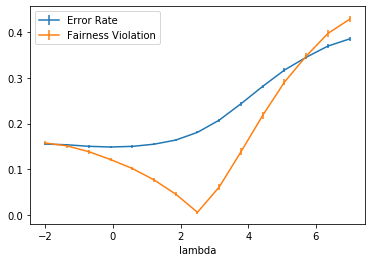

In [134]:
## STD for plot

ll_fair, ll_score = [], []
for random_state in range(10):
    print(random_state)
    X_train, X_test, y_train, y_test,\
         protected_train, protected_test = get_adult(random_state=random_state)
    
    lambda_ = 0
    lr = LogisticRegression(solver='lbfgs', max_iter=1000)
    lr.fit(X_train, y_train)

    l_lambda = []
    l_delta = []
    l_score_test_err = []
    l_fairness_violation = []
    for t in np.linspace(-2,7, 15):  # range(100): #2.507586
        print(int(t), end=' ')
    #     delta = fairness_violation(lr.predict(X_train), y_train,
    #                                protected_train, notion='demographic_parity')
    #     l_delta.append(delta)
    #     lambda_ = lambda_ - delta
        lambda_ = t
        l_lambda.append(lambda_)
        w = reweigth_samples(lambda_, protected_train, y_train)
        lr.fit(X_train, y_train, sample_weight=w)
        l_score_test_err.append(1-lr.score(X_test, y_test))
        l_fairness_violation.append(fairness_violation(lr.predict(X_test), y_test,
                                   protected_test, notion='demographic_parity'))
        
    ll_fair.append(l_fairness_violation)
    ll_score.append(l_score_test_err)
    
plt.errorbar(l_lambda, np.mean(ll_score, axis=0), yerr=np.std(ll_score, axis=0), label = 'Error Rate')
plt.errorbar(l_lambda, np.mean(np.abs(ll_fair), axis=0), yerr=np.std(np.abs(ll_fair), axis=0), label = 'Fairness Violation')
plt.xlabel('lambda')
plt.legend()

## 3. With generated data
Here we could have access to `y_true` and `y_bias`

In [170]:

from sklearn.datasets import make_classification

def get_generated_data(n_samples=5000, random_state=42):
    # generate toy data    
    
    np.random.seed(random_state)
    X, y_true = make_classification(n_samples=int(n_samples*1.3),
                                    random_state=random_state) 
    protected_group = X[:,0] > 0 
    
    y_bias = y_true.copy()
    for i in range(len(X)):
        if protected_group[i]:
            if y_true[i]:
                y_bias[i] = np.random.binomial(1, .7)

    #y_bias[y_true[protected_group]>0] = np.random.binomial(1, .7,
    #                                            size = sum(y_true[protected_group]>0))

    return train_test_split(X, y_true, y_bias,
                            protected_group,
                            random_state=random_state)
    
    
X_train, X_test,\
y_true_train, y_true_test,\
y_bias_train, y_bias_test,\
protected_train, protected_test = get_generated_data()

y_train, y_test = y_bias_train, y_bias_test

In [171]:
lr = LogisticRegression(solver='lbfgs', max_iter=300)
lr.fit(X_train, y_bias_train)
print('Error on test set =', 1-lr.score(X_test, y_bias_test))
y_pred = lr.predict(X_test)

Error on test set = 0.15138461538461534


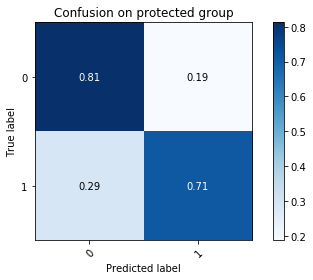

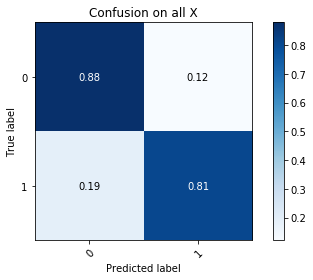

In [172]:
plot_confusion_matrix(y_bias_test[protected_test], y_pred[protected_test], ['0', '1'], normalize=True, title='Confusion on protected group')
plot_confusion_matrix(y_bias_test, y_pred, ['0', '1'], normalize=True, title='Confusion on all X')

-2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 

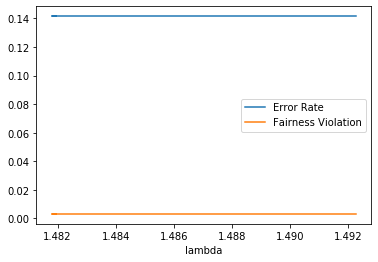

In [179]:
#### with generated


lambda_ = 1.45
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr.fit(X_train, y_train)

l_lambda = []
l_delta = []
l_score_test_err = []
l_fairness_violation = []
for t in np.linspace(-2,7, 125):  # range(100): #2.507586
    print(int(t), end=' ')
#     delta = fairness_violation(lr.predict(X_train), y_train,
#                                protected_train, notion='demographic_parity')
#     l_delta.append(delta)
#     lambda_ = lambda_ - delta
    lambda_ = t
    l_lambda.append(lambda_)
    w = reweigth_samples(lambda_, protected_train, y_train)
    lr.fit(X_train, y_train, sample_weight=w)
    l_score_test_err.append(1-lr.score(X_test, y_test))
    l_fairness_violation.append(fairness_violation(lr.predict(X_test), y_test,
                               protected_test, notion='equal_opportunity'))

plt.plot(l_lambda, l_score_test_err, label = 'Error Rate')
plt.plot(l_lambda, np.abs(l_fairness_violation), label = 'Fairness Violation')
plt.xlabel('lambda')
plt.legend()

In [186]:
w = reweigth_samples(1.48, protected_train, y_train)
lr = LogisticRegression(solver='lbfgs', max_iter=300)
lr.fit(X_train, y_bias_train, sample_weight=w)
print('Error on test set =', 1-lr.score(X_test, y_bias_test))
y_pred = lr.predict(X_test)

Error on test set = 0.1421538461538462


In [183]:
# w = reweigth_samples(1.48, protected_train, y_true_train)
lr = LogisticRegression(solver='lbfgs', max_iter=300)
lr.fit(X_train, y_true_train)
print('Error on test set =', 1-lr.score(X_test, y_true_test))
y_pred = lr.predict(X_test)

Error on test set = 0.07753846153846156
